# Reach-to-Height Ratio Analysis

**Following up on findings from the initial data exploration...**

In my first analysis it was noticed that reach had a small positive correlation with win rate. But that doesn't really tell us much because taller fighters naturally have longer reach. What we really want to know is: **do fighters with proportionally longer arms (relative to their height) have an advantage?**

This factor is a key reason why Floyd Mayweather is such a good boxer (even if not in MMA), he has super long arms for his body size and can easily play defensive and block punches. 

The idea is that if you have long arms relative to your height, you can hit opponents from further away while staying out of their range. This should give you both an offensive advantage (more reach to land strikes) and a defensive advantage (harder for opponent to hit you).

To test this we will calculate a reach-to-height ratio for each fighter. A ratio of 1.0 would mean your reach equals your height (arm span = height), while anything above 1.0 means you have longer arms relative to your height.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')


## 1. Load and Prepare Data

Same data loading process as before. I need to load the fighter attributes, calculate the reach/height ratio, and then merge with fight records to get win rates.

In [3]:
fighter_attributes = pd.read_csv('data/fighter_attributes.csv')
fighter_history = pd.read_csv('data/fighter_history.csv')
fighter_stats = pd.read_csv('data/fighter_stats.csv')

print(f"Fighter Attributes: {fighter_attributes.shape[0]} fighters")
print(f"Fighter History: {fighter_history.shape[0]} fight records")
print(f"Fighter Stats: {fighter_stats.shape[0]} stat records")
print("")

Fighter Attributes: 3035 fighters
Fighter History: 17837 fight records
Fighter Stats: 34586 stat records



In [4]:
fighter_attributes['reach_height_ratio'] = fighter_attributes['reach'] / fighter_attributes['height']

num_valid = fighter_attributes['reach_height_ratio'].notna().sum()
num_total = len(fighter_attributes)
print(f"Fighters with valid reach/height ratio: {num_valid} out of {num_total}")
print(f"\nReach/Height Ratio Stats:")
fighter_attributes['reach_height_ratio'].describe()

Fighters with valid reach/height ratio: 2456 out of 3035

Reach/Height Ratio Stats:


count    2456.000000
mean        1.024554
std         0.028634
min         0.905405
25%         1.000000
50%         1.026667
75%         1.043478
max         1.136364
Name: reach_height_ratio, dtype: float64

Creating the key variable: reach divided by height. A ratio of 1.0 would mean reach equals height (like if you spread your arms out, your wingspan equals your height). A ratio above 1.0 means you have longer arms relative to your height.

In [5]:
fighter_wins_losses = fighter_history.groupby('fighter_id').agg({
    'fight_result': [
        lambda x: (x == 'W').sum(),
        lambda x: (x == 'L').sum(),
        'count'
    ],
    'fighter_name': 'first'
})

fighter_wins_losses.columns = ['wins', 'losses', 'total_fights', 'fighter_name']
fighter_wins_losses['win_rate'] = fighter_wins_losses['wins'] / fighter_wins_losses['total_fights']
fighter_wins_losses = fighter_wins_losses.reset_index()

print(f"Fighters with records: {len(fighter_wins_losses)}")
print("")
fighter_wins_losses.head()

Fighters with records: 3015



,fighter_id,wins,losses,total_fights,fighter_name,win_rate
0,2220951,6,5,12,greg hardy,0.500000
1,2223033,2,5,8,austen lane,0.250000
2,2312150,5,2,7,mohammed usman,0.714286
3,2335243,9,10,19,carlos condit,0.473684
4,2335256,1,3,4,carmelo marrero,0.250000


calculated win/loss records for each fighter. 

In [6]:
agg_stats = fighter_stats.groupby('fighter_id').agg({
    'TSL': 'sum',
    'TSA': 'sum',
    'SSL': 'sum',
    'SSA': 'sum',
    'SCBA': 'sum',
    'SCHA': 'sum',
    'SGBA': 'sum',
    'SGHA': 'sum',
    'SDBA': 'sum',
    'SDHA': 'sum',
    'SDLA': 'sum',
    'KD': 'sum',
    'TDL': 'sum',
    'TDA': 'sum'
})

agg_stats = agg_stats.reset_index()

agg_stats['total_strikes_absorbed'] = (agg_stats['SDBA'] + agg_stats['SDHA'] + 
                                       agg_stats['SDLA'] + agg_stats['SCBA'] + 
                                       agg_stats['SCHA'] + agg_stats['SGBA'] + 
                                       agg_stats['SGHA'])
agg_stats['strike_accuracy'] = agg_stats['SSL'] / agg_stats['SSA']
agg_stats['takedown_accuracy'] = agg_stats['TDL'] / agg_stats['TDA']

agg_stats.head()

,fighter_id,TSL,TSA,SSL,SSA,SCBA,SCHA,SGBA,SGHA,SDBA,SDHA,SDLA,KD,TDL,TDA,total_strikes_absorbed,strike_accuracy,takedown_accuracy
0,2220951,398,757,363,721,4,13,3,89,68,433,111,3,1,3,721,0.503467,0.333333
1,2223033,199,342,108,212,2,3,3,45,33,103,23,1,4,14,212,0.509434,0.285714
2,2312150,416,940,310,791,3,8,0,10,173,593,4,1,3,21,791,0.391909,0.142857
3,2335243,1723,3316,969,2496,40,119,8,165,278,1583,297,6,9,22,2490,0.388221,0.409091
4,2335256,97,157,27,83,2,3,10,22,2,39,5,0,6,15,83,0.325301,0.400000


I also want to grab the detailed fight statistics. For this analysis I specifically want to look at defensive stats (strikes absorbed) to test my hypothesis that longer reach helps with protection.

In [7]:
df = fighter_attributes.merge(fighter_wins_losses, on='fighter_id', how='inner')
df = df.merge(agg_stats, on='fighter_id', how='left')

MIN_FIGHTS = 3
df_analysis = df[(df['reach_height_ratio'].notna()) & (df['total_fights'] >= MIN_FIGHTS)]
df_analysis = df_analysis.copy()

print(f"Fighters for analysis (min {MIN_FIGHTS} fights, valid ratio): {len(df_analysis)}")
print(f"\nColumns available: {list(df_analysis.columns)}")

Fighters for analysis (min 3 fights, valid ratio): 1797

Columns available: ['fighter_id', 'name', 'height', 'weight', 'age', 'dob', 'gender', 'weight_class', 'reach', 'stance', 'style', 'gym', 'country', 'reach_height_ratio', 'wins', 'losses', 'total_fights', 'fighter_name', 'win_rate', 'TSL', 'TSA', 'SSL', 'SSA', 'SCBA', 'SCHA', 'SGBA', 'SGHA', 'SDBA', 'SDHA', 'SDLA', 'KD', 'TDL', 'TDA', 'total_strikes_absorbed', 'strike_accuracy', 'takedown_accuracy']


## 2. Reach-to-Height Ratio Distribution

Let me start by looking at the distribution of this ratio. 

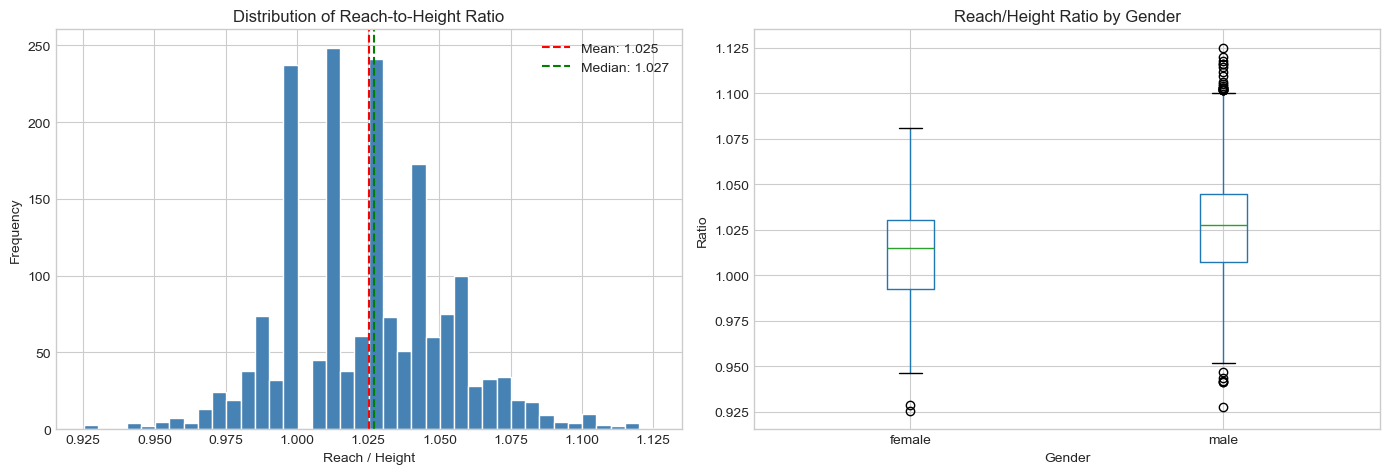


A ratio of 1.0 means reach equals height.
Ratios > 1.0 indicate longer arms relative to height.


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ratio_data = df_analysis['reach_height_ratio']
axes[0].hist(ratio_data, bins=40, color='steelblue', edgecolor='white')
mean_val = df_analysis['reach_height_ratio'].mean()
median_val = df_analysis['reach_height_ratio'].median()
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
axes[0].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.3f}')
axes[0].set_title('Distribution of Reach-to-Height Ratio')
axes[0].set_xlabel('Reach / Height')
axes[0].set_ylabel('Frequency')
axes[0].legend()

df_analysis.boxplot(column='reach_height_ratio', by='gender', ax=axes[1])
axes[1].set_title('Reach/Height Ratio by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Ratio')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nA ratio of 1.0 means reach equals height.")
print(f"Ratios > 1.0 indicate longer arms relative to height.")

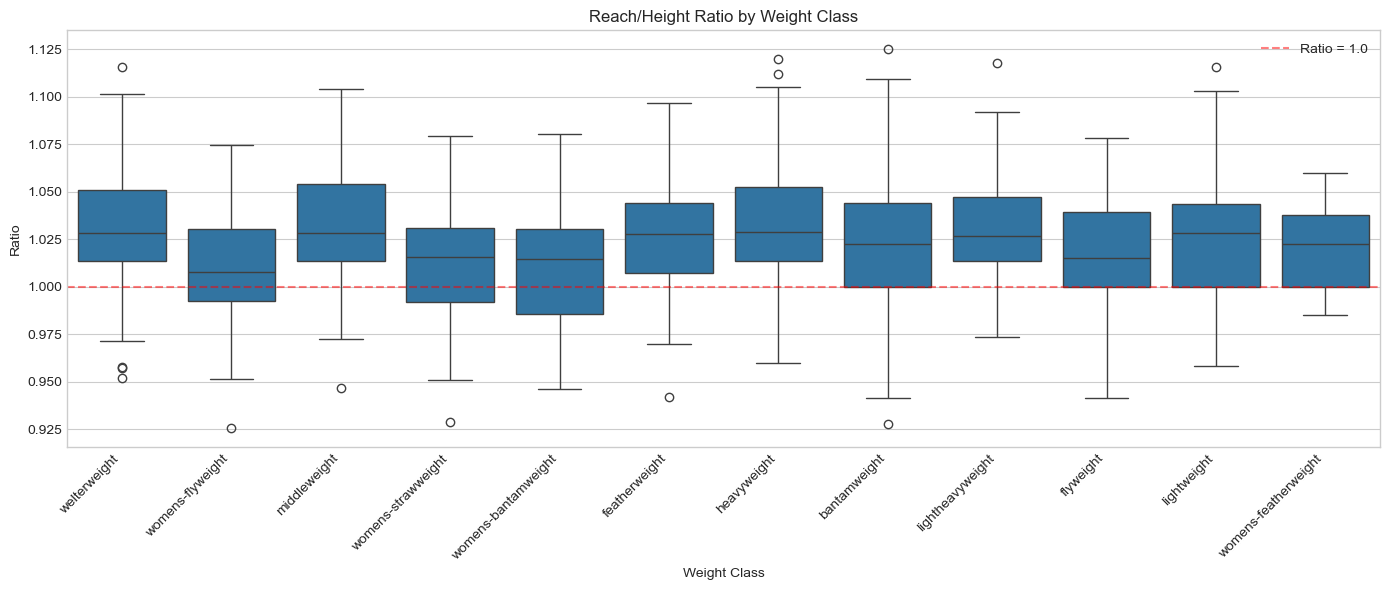

In [9]:
top_weight_classes = df_analysis['weight_class'].value_counts().head(12).index
df_for_plot = df_analysis[df_analysis['weight_class'].isin(top_weight_classes)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_for_plot, x='weight_class', y='reach_height_ratio')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Ratio = 1.0')
plt.title('Reach/Height Ratio by Weight Class')
plt.xlabel('Weight Class')
plt.ylabel('Ratio')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Distribution looks pretty normal - centered around 1.02-1.03 meaning most fighters have arms slightly longer than their height. Males and females look similar.

Below that is if this varies by weight class.

Pretty consistent across weight classes, maybe slightly higher for heavier weights. main question - **does this ratio correlate with winning?**

This is basically asking: does having proportionally longer arms give you a fighting advantage?

## 3. Reach/Height Ratio vs Win Rate - The Main Question



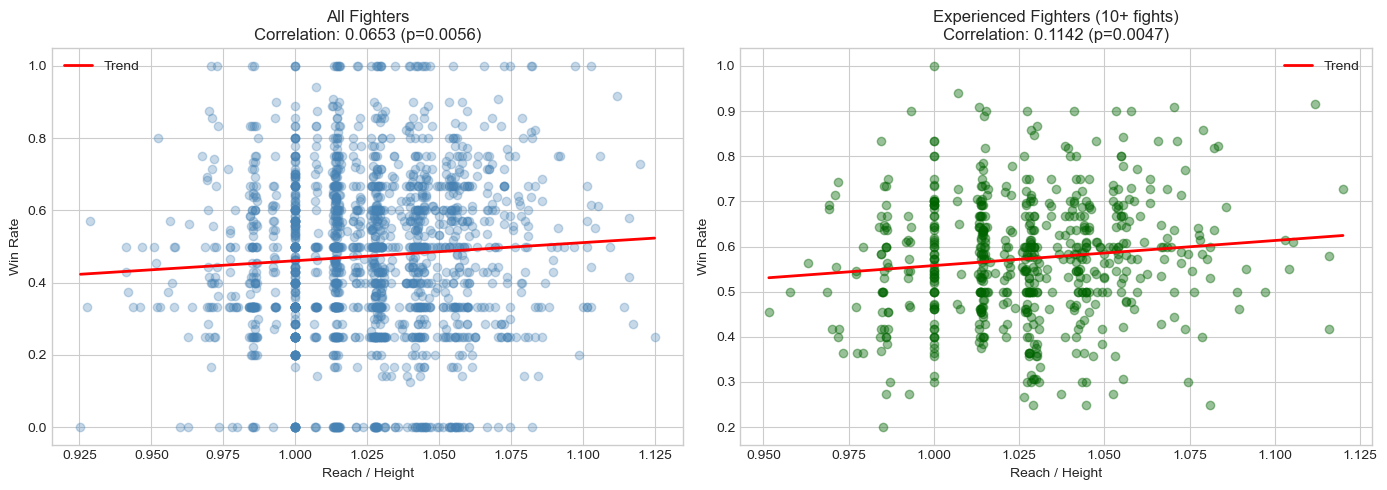

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_analysis['reach_height_ratio'], df_analysis['win_rate'], alpha=0.3, c='steelblue')

z = np.polyfit(df_analysis['reach_height_ratio'], df_analysis['win_rate'], 1)
p = np.poly1d(z)
x_vals = np.linspace(df_analysis['reach_height_ratio'].min(), df_analysis['reach_height_ratio'].max(), 100)
axes[0].plot(x_vals, p(x_vals), 'r-', linewidth=2, label='Trend')

corr, p_value = pearsonr(df_analysis['reach_height_ratio'], df_analysis['win_rate'])
axes[0].set_title(f'All Fighters\nCorrelation: {corr:.4f} (p={p_value:.4f})')
axes[0].set_xlabel('Reach / Height')
axes[0].set_ylabel('Win Rate')
axes[0].legend()

df_experienced = df_analysis[df_analysis['total_fights'] >= 10]
axes[1].scatter(df_experienced['reach_height_ratio'], df_experienced['win_rate'], alpha=0.4, c='darkgreen')

z2 = np.polyfit(df_experienced['reach_height_ratio'], df_experienced['win_rate'], 1)
p2 = np.poly1d(z2)
x_vals2 = np.linspace(df_experienced['reach_height_ratio'].min(), df_experienced['reach_height_ratio'].max(), 100)
axes[1].plot(x_vals2, p2(x_vals2), 'r-', linewidth=2, label='Trend')

corr2, p_value2 = pearsonr(df_experienced['reach_height_ratio'], df_experienced['win_rate'])
axes[1].set_title(f'Experienced Fighters (10+ fights)\nCorrelation: {corr2:.4f} (p={p_value2:.4f})')
axes[1].set_xlabel('Reach / Height')
axes[1].set_ylabel('Win Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

There does appear to be some correlation of this in all fighters and those fighters who have 10+ fights. 


## Analysis by Stance



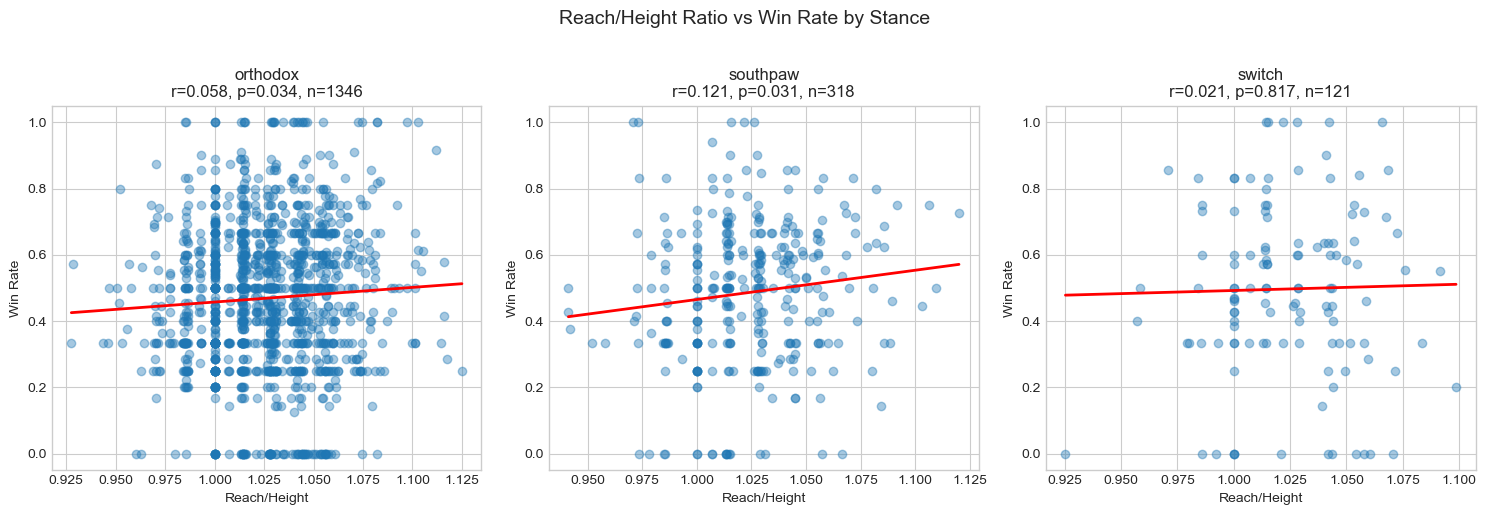

In [19]:
all_stances = df_analysis['stance'].dropna().unique()
stance_counts = df_analysis.groupby('stance').size()
stances_with_enough_data = stance_counts[stance_counts >= 30].index

fig, axes = plt.subplots(1, len(stances_with_enough_data), figsize=(5*len(stances_with_enough_data), 5))
if len(stances_with_enough_data) == 1:
    axes = [axes]

correlations_by_stance = {}

for i, stance in enumerate(stances_with_enough_data):
    ax = axes[i]
    stance_data = df_analysis[df_analysis['stance'] == stance]
    
    ax.scatter(stance_data['reach_height_ratio'], stance_data['win_rate'], alpha=0.4)
    
    z = np.polyfit(stance_data['reach_height_ratio'], stance_data['win_rate'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(stance_data['reach_height_ratio'].min(), stance_data['reach_height_ratio'].max(), 100)
    ax.plot(x_range, p(x_range), 'r-', linewidth=2)
    
    corr_val, p_val = pearsonr(stance_data['reach_height_ratio'], stance_data['win_rate'])
    correlations_by_stance[stance] = {'corr': corr_val, 'p_value': p_val, 'n': len(stance_data)}
    
    ax.set_title(f'{stance}\nr={corr_val:.3f}, p={p_val:.3f}, n={len(stance_data)}')
    ax.set_xlabel('Reach/Height')
    ax.set_ylabel('Win Rate')

plt.suptitle('Reach/Height Ratio vs Win Rate by Stance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [20]:
stance_results = pd.DataFrame(correlations_by_stance).T
stance_results = stance_results.sort_values('corr', ascending=False)
print("Correlation by Stance:")
print("="*60)
stance_results

Correlation by Stance:


,corr,p_value,n
southpaw,0.120931,0.031089,318.0
orthodox,0.057724,0.034213,1346.0
switch,0.021220,0.817296,121.0


This relationship seems to affect win rate for the southpaw stance the most. 

## 5. Analysis for Strikers vs Non-Strikers

My hypothesis was that longer reach helps with protection - keeping opponents at a distance. This should matter more for strikers (who fight at range) than for grapplers (who fight up close).

Let me test this by separating strikers from non-strikers based on fighting style.

In [21]:
striking_styles = ['striker', 'muay thai', 'boxing', 'kickboxer', 'karate']
df_analysis['is_striker'] = df_analysis['style'].str.lower().isin(striking_styles)

num_strikers = df_analysis['is_striker'].sum()
num_non_strikers = (~df_analysis['is_striker']).sum()
print(f"Strikers: {num_strikers}")
print(f"Non-strikers: {num_non_strikers}")

Strikers: 552
Non-strikers: 1245


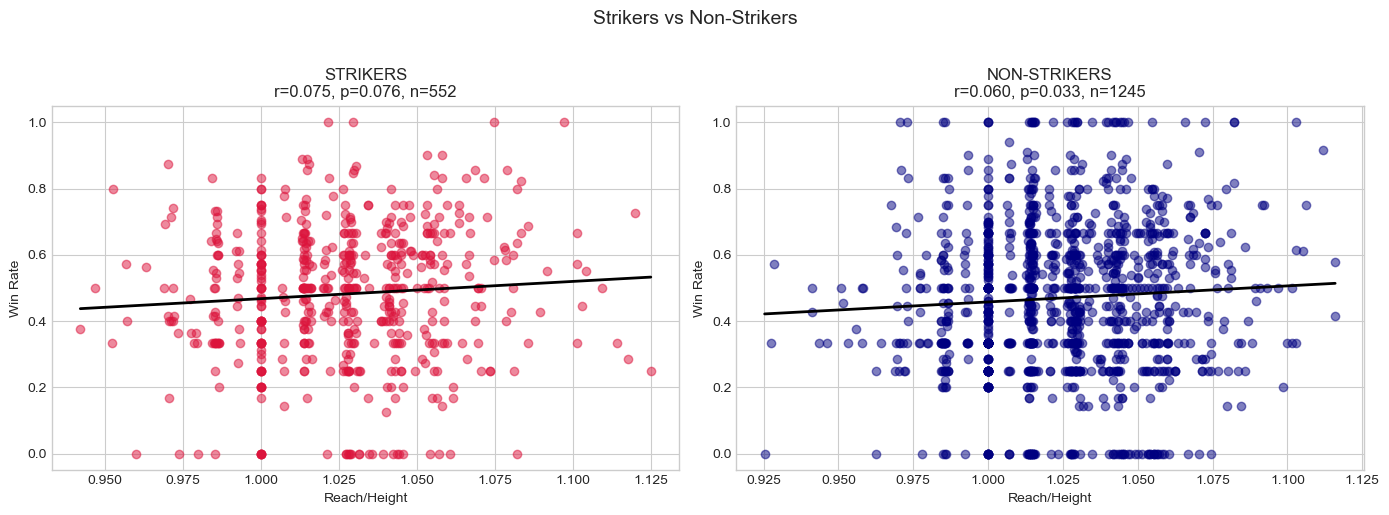

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strikers = df_analysis[df_analysis['is_striker'] == True]
if len(strikers) >= 10:
    axes[0].scatter(strikers['reach_height_ratio'], strikers['win_rate'], alpha=0.5, c='crimson')
    z = np.polyfit(strikers['reach_height_ratio'], strikers['win_rate'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(strikers['reach_height_ratio'].min(), strikers['reach_height_ratio'].max(), 100)
    axes[0].plot(x_range, p(x_range), 'k-', linewidth=2)
    
    corr_strikers, pval_strikers = pearsonr(strikers['reach_height_ratio'], strikers['win_rate'])
    axes[0].set_title(f'STRIKERS\nr={corr_strikers:.3f}, p={pval_strikers:.3f}, n={len(strikers)}')
else:
    axes[0].text(0.5, 0.5, 'Not enough striker data', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('STRIKERS')
    corr_strikers = 0
    pval_strikers = 1

axes[0].set_xlabel('Reach/Height')
axes[0].set_ylabel('Win Rate')

non_strikers = df_analysis[df_analysis['is_striker'] == False]
axes[1].scatter(non_strikers['reach_height_ratio'], non_strikers['win_rate'], alpha=0.5, c='navy')
z2 = np.polyfit(non_strikers['reach_height_ratio'], non_strikers['win_rate'], 1)
p2 = np.poly1d(z2)
x_range2 = np.linspace(non_strikers['reach_height_ratio'].min(), non_strikers['reach_height_ratio'].max(), 100)
axes[1].plot(x_range2, p2(x_range2), 'k-', linewidth=2)

corr_non_strikers, pval_non_strikers = pearsonr(non_strikers['reach_height_ratio'], non_strikers['win_rate'])
axes[1].set_title(f'NON-STRIKERS\nr={corr_non_strikers:.3f}, p={pval_non_strikers:.3f}, n={len(non_strikers)}')
axes[1].set_xlabel('Reach/Height')
axes[1].set_ylabel('Win Rate')

plt.suptitle('Strikers vs Non-Strikers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [23]:
def calc_style_correlation(group):
    if len(group) >= 10:
        corr, pval = pearsonr(group['reach_height_ratio'], group['win_rate'])
        return pd.Series({
            'n': len(group),
            'mean_ratio': group['reach_height_ratio'].mean(),
            'mean_win_rate': group['win_rate'].mean(),
            'correlation': corr,
            'p_value': pval
        })
    else:
        return pd.Series({
            'n': len(group),
            'mean_ratio': group['reach_height_ratio'].mean(),
            'mean_win_rate': group['win_rate'].mean(),
            'correlation': np.nan,
            'p_value': np.nan
        })

style_results = df_analysis.groupby('style').apply(calc_style_correlation).dropna()
style_results = style_results[style_results['n'] >= 20]
style_results = style_results.sort_values('correlation', ascending=False)

print("Correlation by Fighting Style (min 20 fighters):")
print("="*70)
style_results.round(4)

Correlation by Fighting Style (min 20 fighters):


,n,mean_ratio,mean_win_rate,correlation,p_value
style,,,,,
boxing,26.0,1.0296,0.4934,0.2417,0.2342
jiu-jitsu,24.0,1.0136,0.5359,0.1994,0.3503
wrestling,110.0,1.0326,0.5754,0.1128,0.2405
striker,483.0,1.0268,0.4819,0.0818,0.0726
mixed martial artist,197.0,1.0264,0.5166,0.0696,0.3314
brazilian jiu-jitsu,306.0,1.0257,0.4745,0.0592,0.3022
freestyle,57.0,1.0238,0.5226,-0.0646,0.6330
muay thai,35.0,1.0259,0.4605,-0.2014,0.2461
kickboxing,26.0,1.0323,0.5504,-0.2755,0.1731


Let me also look at individual fighting styles to see if there are any where reach ratio matters more.

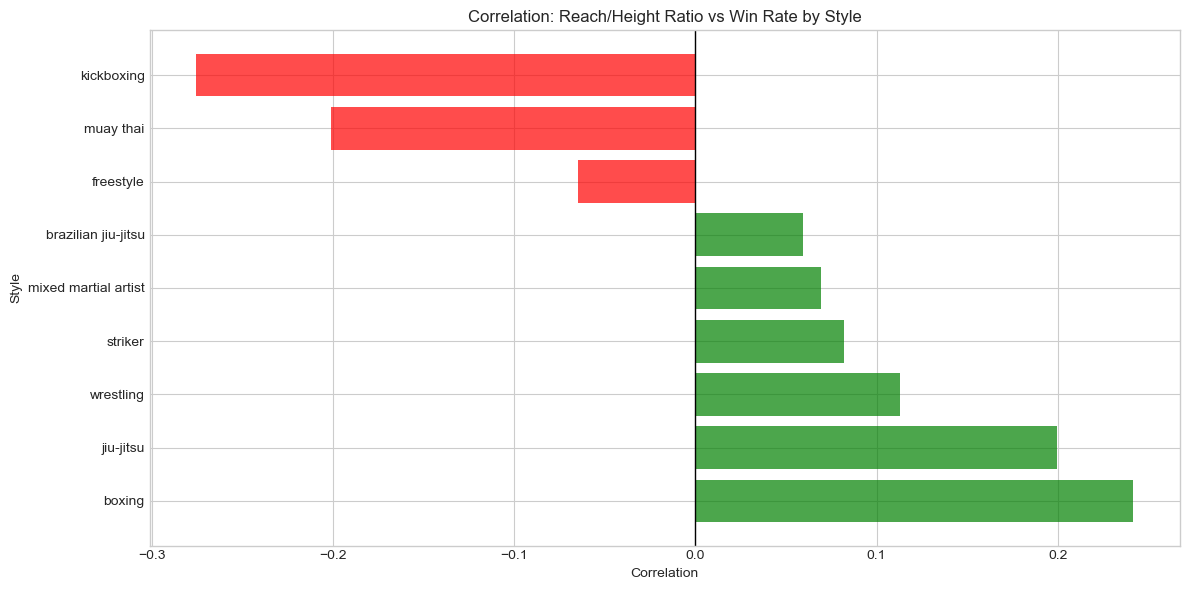

* = significant at p<0.05


In [24]:
if len(style_results) > 0:
    plt.figure(figsize=(12, 6))
    bar_colors = []
    for corr_value in style_results['correlation']:
        if corr_value > 0:
            bar_colors.append('green')
        else:
            bar_colors.append('red')
    
    bars = plt.barh(style_results.index, style_results['correlation'], color=bar_colors, alpha=0.7)
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.title('Correlation: Reach/Height Ratio vs Win Rate by Style')
    plt.xlabel('Correlation')
    plt.ylabel('Style')
    
    for i, row in enumerate(style_results.itertuples()):
        if row.p_value < 0.05:
            x_offset = 0.01 if row.correlation > 0 else -0.01
            alignment = 'left' if row.correlation > 0 else 'right'
            plt.text(row.correlation + x_offset, i, '*', fontsize=14, va='center', ha=alignment)
    
    plt.tight_layout()
    plt.show()
    print("* = significant at p<0.05")

Boxing seems to have the most correlation, this makes sense as this is where the advantage would help the most. One thing that was surprising that we did not initially think about was that the reach/height ratio does impact jui-jistu , we think that this may be because you have more torque that you are able to work with when defending. 

## Thoughts

The reach-to-height ratio does show a slight positive correlation with win rate - fighters with proportionally longer arms do seem to win slightly more often. The effect is statistically significant but pretty weak (r=0.065).

Overall, reach/height ratio seems to have a small positive effect on fight outcomes, but it's not a strong predictor of overall success and mainly impacts those fighting tyles that consist of standing and punching (boxing). There are probably other factors that matter more.

Based on the groups knowledge of the UFC, wrestlers from Russia are known to be dominant. 

This will be explored that in my next analysis.